In [2]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from umap import UMAP

# Define paths (adjust to your filenames)
model_paths = {
    "Glove200": "glove_200_embeddings.npy",
    "Word2Vec": "word_2_vec_embeddings.npy",
    "RoBERTa": "all_distill_roberta_embeddings.npy",
    "Gemma": "gemma_embeddings.npy",
    "HKU_INSTRUCTOR": "hku_nlp_instructor_base_embeddings.npy",
    "MiniLM-L6": "mini_LM_6_embeddings.npy",
    "MiniLM-L12": "mini_LM_12_embeddings.npy",
    "Paraphrase-MPNET": "paraphrase_mpnet_embeddings.npy",
    "Paraphrase-MiniLM-L3": "paraphrase_LM_3_embeddings.npy",
    "Open-AI-Text-Embedding": "open_ai_1000_sample_embeddings.npy"
}

# Load and normalize embeddings
models = {}
for name, path in model_paths.items():
    emb = np.load(f"embeddings/{path}")[:200]
    models[name] = normalize(emb)
    print(f"{name:25s} loaded: {emb.shape}")

Glove200                  loaded: (200, 200)
Word2Vec                  loaded: (200, 200)
RoBERTa                   loaded: (200, 768)
Gemma                     loaded: (200, 1152)
HKU_INSTRUCTOR            loaded: (200, 768)
MiniLM-L6                 loaded: (200, 384)
MiniLM-L12                loaded: (200, 384)
Paraphrase-MPNET          loaded: (200, 768)
Paraphrase-MiniLM-L3      loaded: (200, 384)
Open-AI-Text-Embedding    loaded: (200, 1536)


In [3]:
# Evaluate KMeans clustering on normalized embeddings
k = 8  # number of clusters (you can adjust later)
results = {}

print("\n=== Normalized Embedding Clustering Comparison (KMeans k=8) ===")
for name, emb in models.items():
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(emb)
    score = silhouette_score(emb, labels)
    results[name] = score
    print(f"{name:25s} → Silhouette: {score:.3f}")

# Sort results by silhouette score
sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

print("\n=== Sorted by Silhouette (Normalized) ===")
for name, score in sorted_results.items():
    print(f"{name:25s} → {score:.3f}")


=== Normalized Embedding Clustering Comparison (KMeans k=8) ===
Glove200                  → Silhouette: 0.039
Word2Vec                  → Silhouette: 0.100
RoBERTa                   → Silhouette: 0.017
Gemma                     → Silhouette: 0.028
HKU_INSTRUCTOR            → Silhouette: 0.028
MiniLM-L6                 → Silhouette: 0.027
MiniLM-L12                → Silhouette: 0.032
Paraphrase-MPNET          → Silhouette: 0.040
Paraphrase-MiniLM-L3      → Silhouette: 0.021
Open-AI-Text-Embedding    → Silhouette: 0.028

=== Sorted by Silhouette (Normalized) ===
Word2Vec                  → 0.100
Paraphrase-MPNET          → 0.040
Glove200                  → 0.039
MiniLM-L12                → 0.032
Gemma                     → 0.028
HKU_INSTRUCTOR            → 0.028
Open-AI-Text-Embedding    → 0.028
MiniLM-L6                 → 0.027
Paraphrase-MiniLM-L3      → 0.021
RoBERTa                   → 0.017


/Users/safarifgisa/venvs/python3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


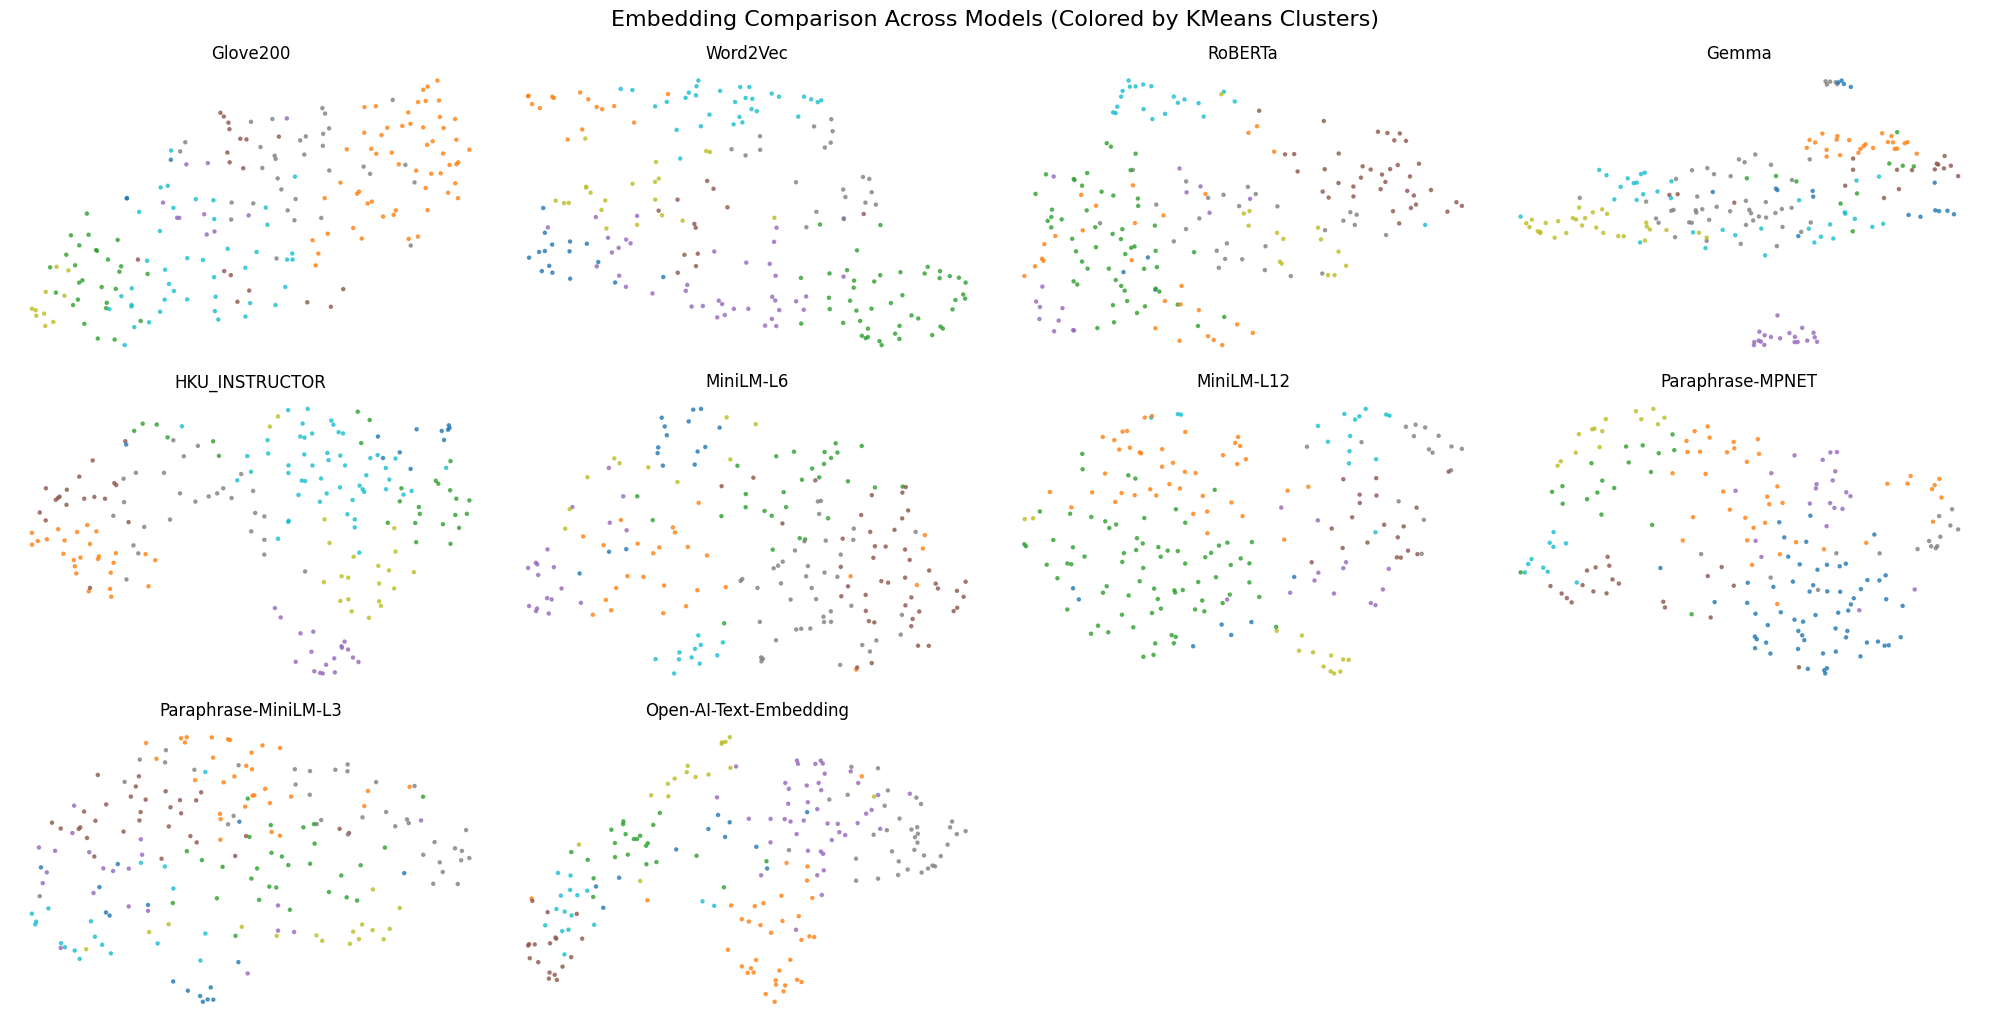

In [4]:
# UMAP visualization with cluster coloring
reducer = UMAP(n_components=2, random_state=42)
n_models = len(models)
n_cols = 4
n_rows = int(np.ceil(n_models / n_cols))

plt.figure(figsize=(20, 10))

for i, (name, emb) in enumerate(models.items()):
    # Cluster the embeddings
    kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
    labels = kmeans.fit_predict(emb)
    
    # Reduce to 2D
    emb_2d = reducer.fit_transform(emb)
    
    # Plot clusters
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=labels,
        s=5,
        cmap='tab10',
        alpha=0.7
    )
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Embedding Comparison Across Models (Colored by KMeans Clusters)", fontsize=16, y=1.02)
plt.show()


In [5]:
from sklearn.metrics import silhouette_samples
import pandas as pd

k = 8  # same as before

for name, emb in models.items():
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(emb)

    # Compute silhouette value for each sample
    sil_samples = silhouette_samples(emb, labels)

    # Compute average silhouette per cluster
    cluster_sil_means = []
    for cluster_id in range(k):
        cluster_sil_means.append(sil_samples[labels == cluster_id].mean())

    cluster_df = pd.DataFrame({
        "Cluster": range(k),
        "Silhouette": cluster_sil_means
    }).sort_values("Silhouette", ascending=False)

    print(f"\n=== {name} per-cluster Silhouette (K={k}) ===")
    print(cluster_df.to_string(index=False))



=== Glove200 per-cluster Silhouette (K=8) ===
 Cluster  Silhouette
       7    0.109415
       1    0.092321
       2    0.031697
       4   -0.001046
       6   -0.012170
       0   -0.052873
       5   -0.058667
       3   -0.064074

=== Word2Vec per-cluster Silhouette (K=8) ===
 Cluster  Silhouette
       5    0.150845
       2    0.119119
       7    0.103015
       1    0.098755
       0    0.093137
       3    0.076760
       6    0.071977
       4    0.070982

=== RoBERTa per-cluster Silhouette (K=8) ===
 Cluster  Silhouette
       5    0.078295
       0    0.069125
       7    0.033183
       4    0.009471
       2    0.004407
       3    0.003663
       1   -0.007421
       6   -0.010911

=== Gemma per-cluster Silhouette (K=8) ===
 Cluster  Silhouette
       3    0.099540
       1    0.077032
       6    0.059544
       5    0.012775
       4    0.012544
       2    0.006517
       0    0.005234
       7   -0.022261

=== HKU_INSTRUCTOR per-cluster Silhouette (K=8) ===
 Cluste

In [6]:
# Load your original reviews dataframe (adjust file name)
reviews_pandas_df = pd.read_parquet("../filtered/yelp_reviews_2022.parquet").head(2000)

# Check columns
print(reviews_pandas_df['text'][90])

Love Bartaco!!! They require masks which makes me feel extra safe!!! Best drinks and food!!


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Pick an index for the reference review
idx = 90  # example, pick any index from your dataset

# For each model, find top-2 most similar reviews
for name, emb in models.items():
    sim_matrix = cosine_similarity([emb[idx]], emb)[0]
    
    # Get top-2 similar indices (excluding itself)
    top2_idx = np.argsort(sim_matrix)[-3:-1][::-1]
    
    print(f"\n=== {name} ===")
    print(f"Base review (idx={idx}):")
    print(reviews_pandas_df.iloc[idx]['text'])
    
    for i, j in enumerate(top2_idx):
        print(f"\nSimilar {i+1} (idx={j}) | Cosine: {sim_matrix[j]:.3f}")
        print(reviews_pandas_df.iloc[j]['text'])



=== Glove200 ===
Base review (idx=90):
Love Bartaco!!! They require masks which makes me feel extra safe!!! Best drinks and food!!

Similar 1 (idx=152) | Cosine: 0.916
We were about 4th in line but the wait was only about 15 minutes. Very friendly staff! My boyfriend and I were seated in front of the kitchen. We were able to see how quick and efficient the cooks were. Our food came out very quickly. So delicious! I was actually shocked out at good the food was. Also, for seafood, this place gives a lot of high quality food for an affordable price! Tip these people well! They deserve it!

Similar 2 (idx=7) | Cosine: 0.913
Food was good love the Cuban sandwiche 
The place is clean and the employees are so sweet. Would recommend to anyone

=== Word2Vec ===
Base review (idx=90):
Love Bartaco!!! They require masks which makes me feel extra safe!!! Best drinks and food!!

Similar 1 (idx=148) | Cosine: 0.777
I felt like a whole princess for the day at this place. The inside is gorgeous. A wh

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

# Ensure you have: pip install umap-learn matplotlib


In [9]:
reducer = UMAP(n_components=2, random_state=42)
n_models = len(models)  # should be 10
n_cols = 4
n_rows = int(np.ceil(n_models / n_cols))

plt.figure(figsize=(22, 12))


<Figure size 2200x1200 with 0 Axes>

<Figure size 2200x1200 with 0 Axes>

/Users/safarifgisa/venvs/python3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


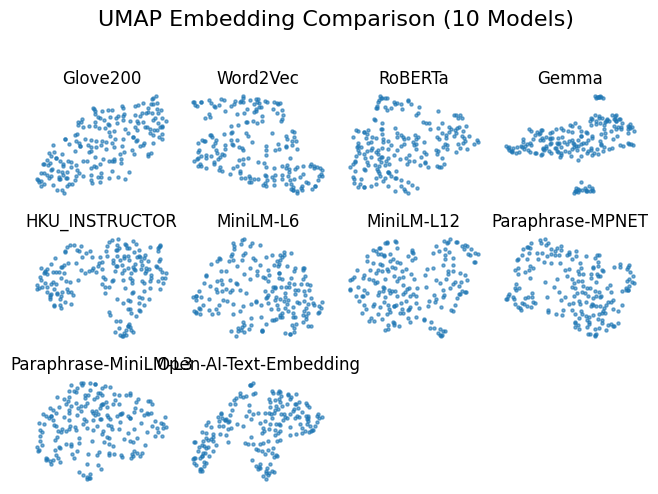

In [10]:
for i, (name, emb) in enumerate(models.items()):
    emb_2d = reducer.fit_transform(emb)
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=5, alpha=0.6)
    plt.title(name)
    plt.axis("off")

plt.suptitle("UMAP Embedding Comparison (10 Models)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


/Users/safarifgisa/venvs/python3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


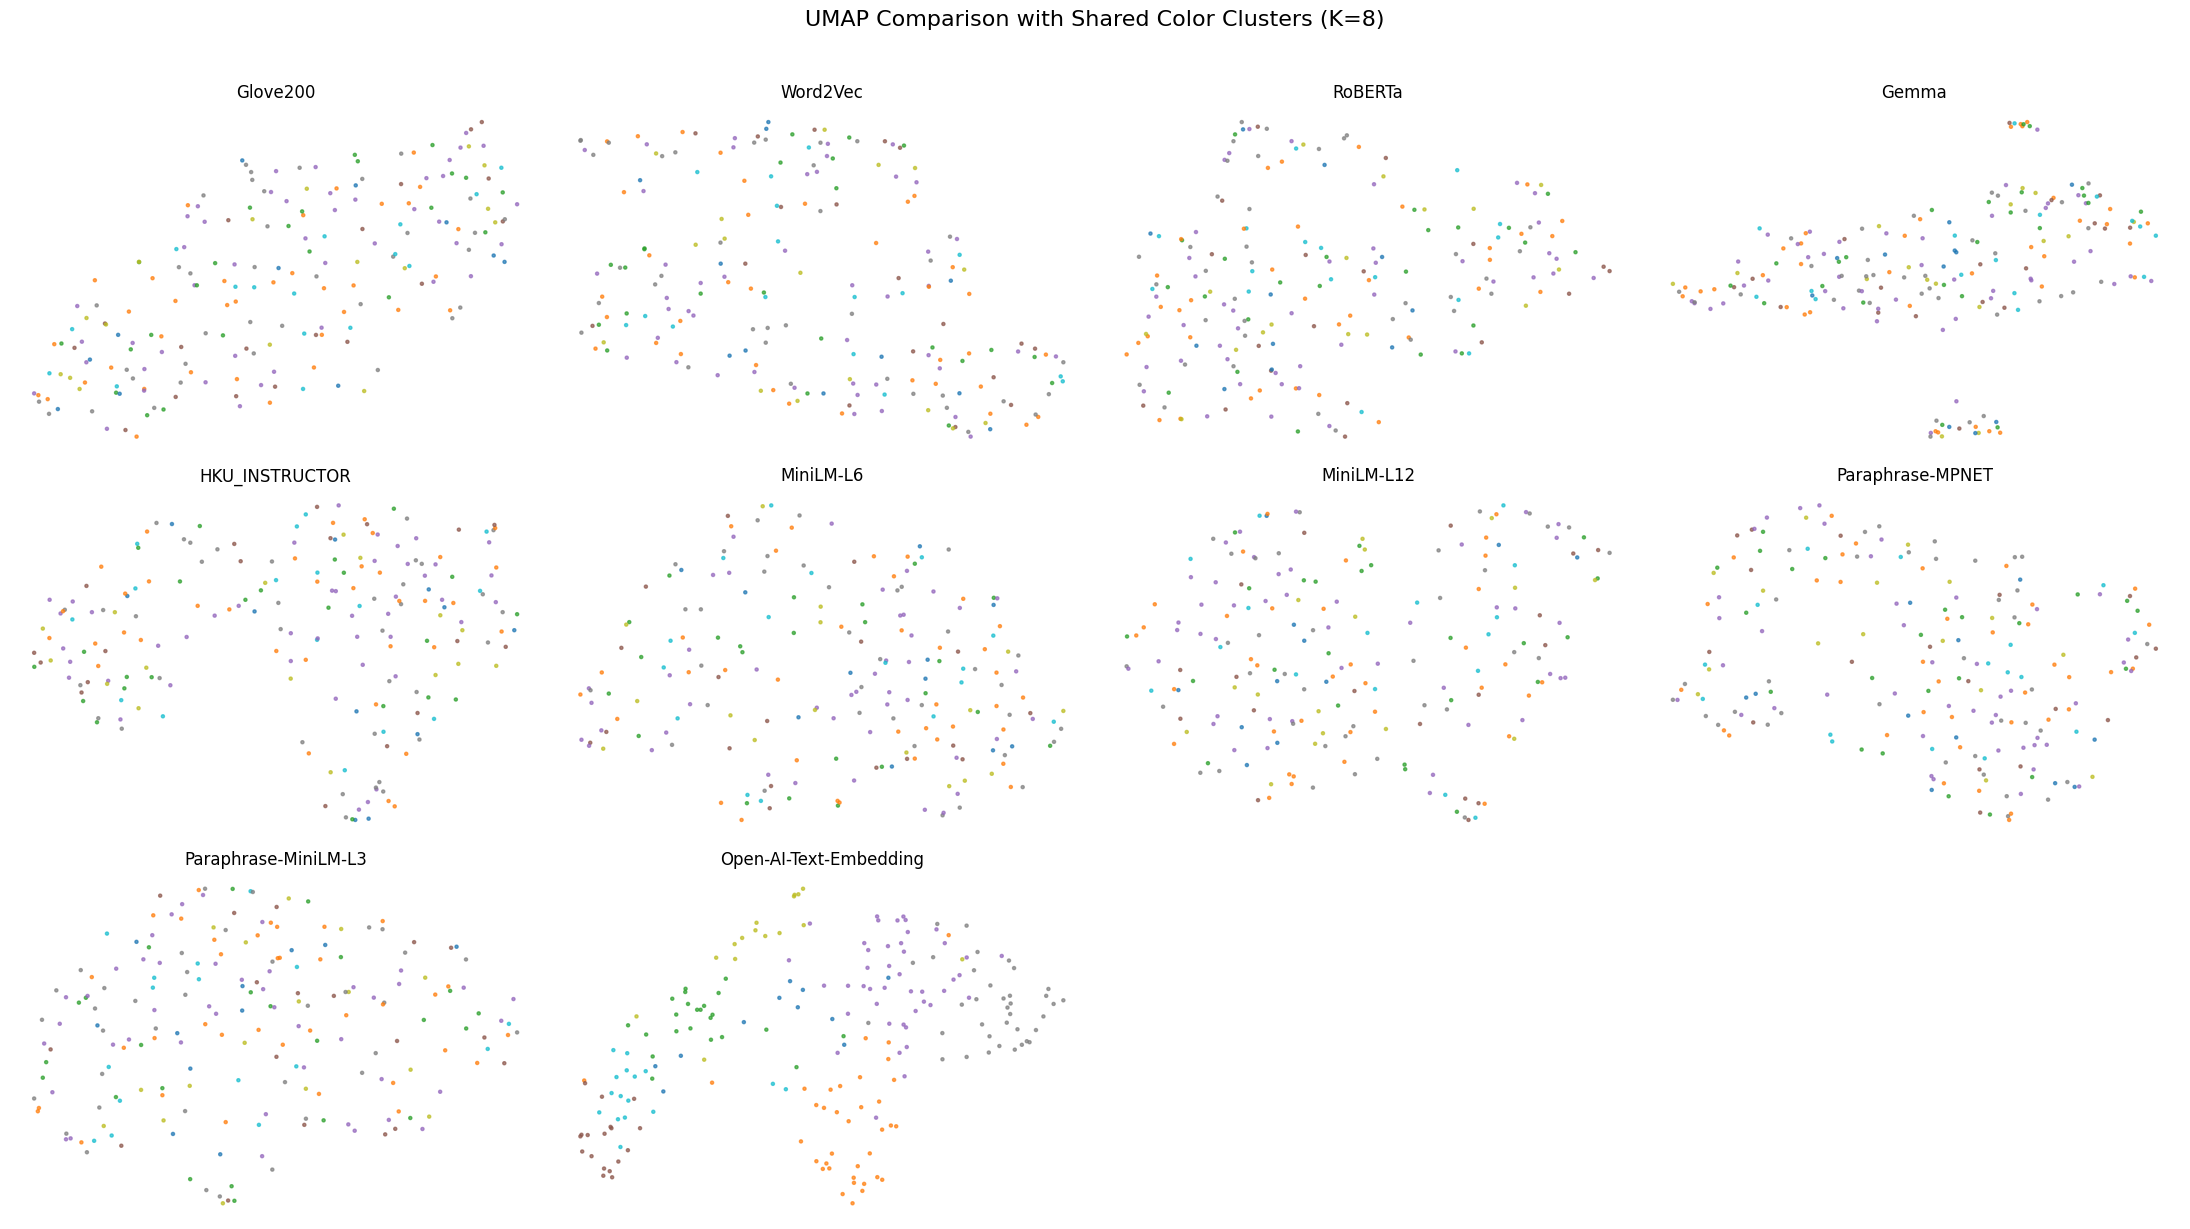

In [11]:
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt

# Cluster once using a reference model (e.g., OpenAI)
reference_model = "Open-AI-Text-Embedding"
kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
ref_labels = kmeans.fit_predict(models[reference_model])

# Use same colors for all models
colors = plt.cm.tab10(ref_labels / ref_labels.max())

# Compute and plot UMAP for all models using the same reducer
reducer = UMAP(n_components=2, random_state=42)
n_cols, n_rows = 4, int(np.ceil(len(models)/4))
plt.figure(figsize=(22, 12))

for i, (name, emb) in enumerate(models.items()):
    emb_2d = reducer.fit_transform(emb)
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors, s=5, alpha=0.7)
    plt.title(name)
    plt.axis("off")

plt.suptitle("UMAP Comparison with Shared Color Clusters (K=8)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random

# Number of random reviews to test
n_samples = 100  

results = {}

for name, emb in models.items():
    similarities = []
    indices = random.sample(range(len(emb)), n_samples)

    for idx in indices:
        # Compute cosine similarity to all reviews
        sims = cosine_similarity([emb[idx]], emb)[0]

        # Exclude self-similarity
        sims[idx] = -1  

        # Get most similar review
        top_idx = np.argmax(sims)
        similarities.append(sims[top_idx])

    avg_sim = np.mean(similarities)
    results[name] = avg_sim
    print(f"{name:25s} → Avg Top-1 Similarity: {avg_sim:.3f}")

# Sort results for clarity
sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
print("\n=== Sorted Semantic Similarity Results ===")
for name, score in sorted_results.items():
    print(f"{name:25s} → {score:.3f}")


Glove200                  → Avg Top-1 Similarity: 0.929
Word2Vec                  → Avg Top-1 Similarity: 0.916
RoBERTa                   → Avg Top-1 Similarity: 0.655
Gemma                     → Avg Top-1 Similarity: 0.650
HKU_INSTRUCTOR            → Avg Top-1 Similarity: 0.942
MiniLM-L6                 → Avg Top-1 Similarity: 0.638
MiniLM-L12                → Avg Top-1 Similarity: 0.662
Paraphrase-MPNET          → Avg Top-1 Similarity: 0.705
Paraphrase-MiniLM-L3      → Avg Top-1 Similarity: 0.564

=== Sorted Semantic Similarity Results ===
HKU_INSTRUCTOR            → 0.942
Glove200                  → 0.929
Word2Vec                  → 0.916
Paraphrase-MPNET          → 0.705
MiniLM-L12                → 0.662
RoBERTa                   → 0.655
Gemma                     → 0.650
MiniLM-L6                 → 0.638
Paraphrase-MiniLM-L3      → 0.564


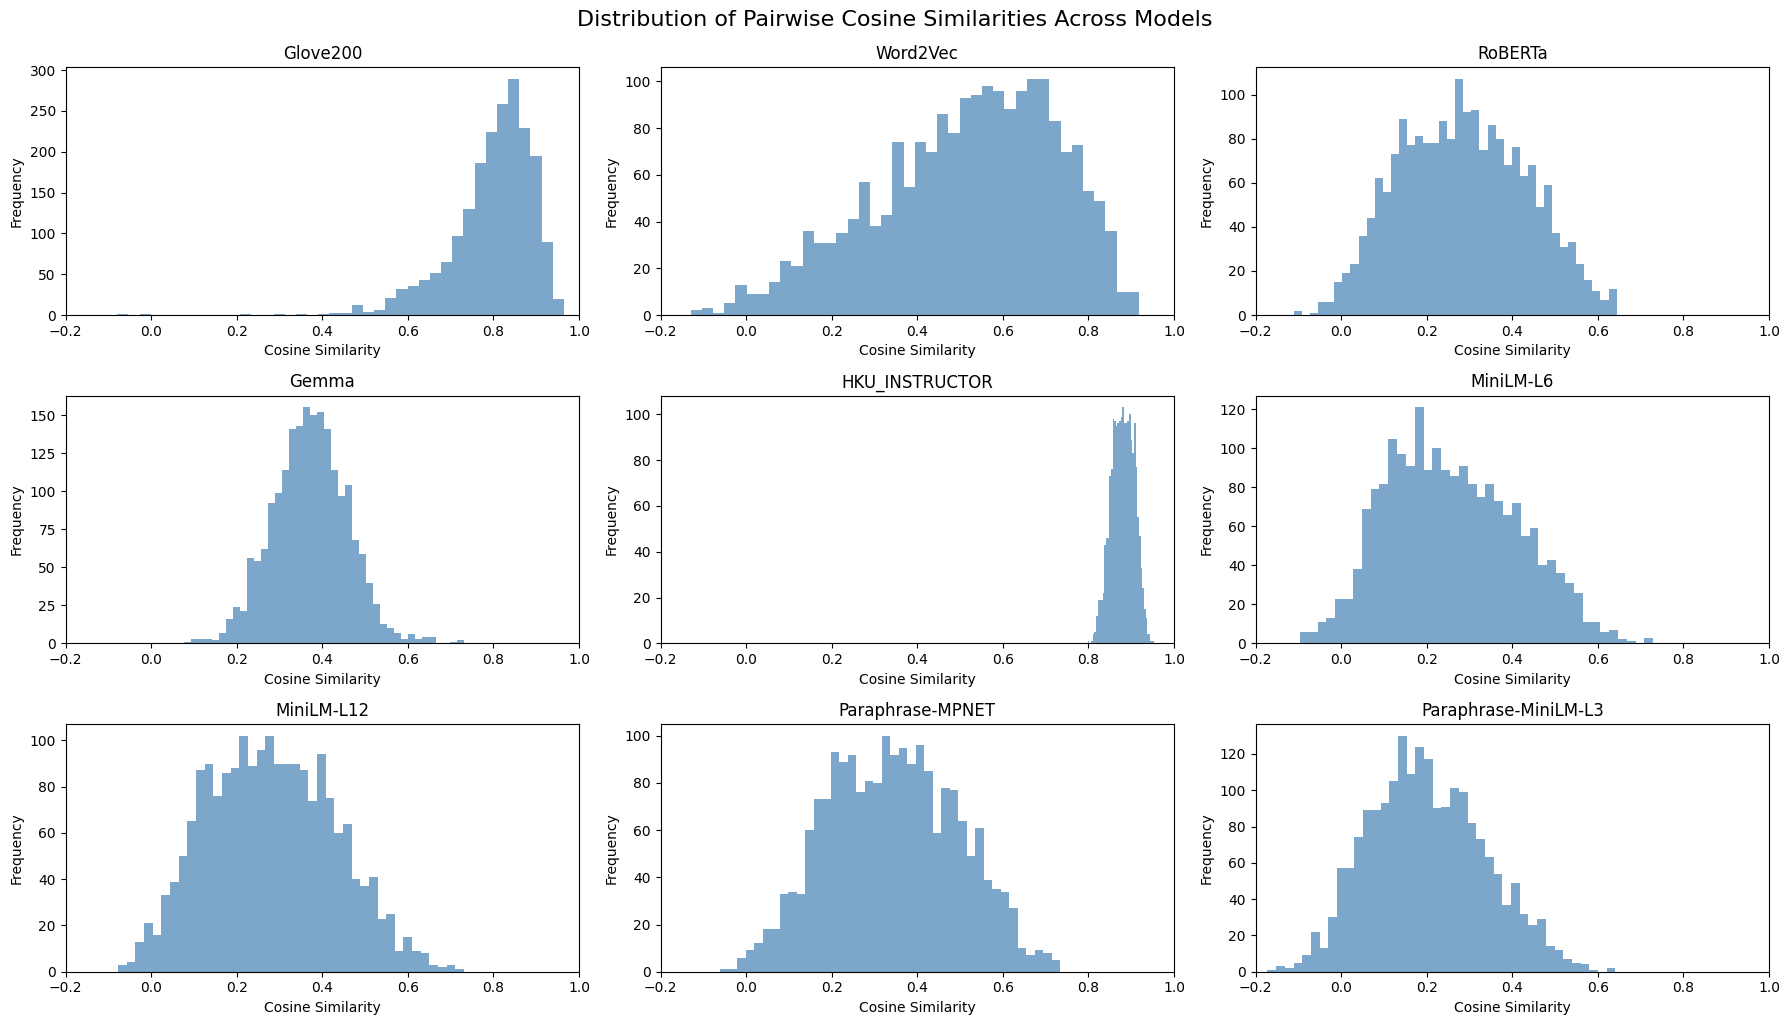

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random

# Number of random pairs to test
n_pairs = 2000  

plt.figure(figsize=(18, 10))
n_cols = 3
n_rows = int(np.ceil(len(models) / n_cols))

for i, (name, emb) in enumerate(models.items()):
    sims = []
    for _ in range(n_pairs):
        a, b = random.sample(range(len(emb)), 2)
        sims.append(cosine_similarity([emb[a]], [emb[b]])[0][0])

    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(sims, bins=40, color='steelblue', alpha=0.7)
    plt.title(name)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.xlim(-0.2, 1.0)

plt.tight_layout()
plt.suptitle("Distribution of Pairwise Cosine Similarities Across Models", fontsize=16, y=1.02)
plt.show()


In [ ]:
# Average pairwise similarity (semantic tightness)
print("\n=== Average Pairwise Cosine Similarity ===")
for name, emb in models.items():
    sim = cosine_similarity(emb[:300])  # sample subset for speed
    avg_sim = np.mean(sim)
    print(f"{name:25s} → Avg Cosine Similarity: {avg_sim:.3f}")

In [ ]:
# 2D visualization (t-SNE)
for name, emb in models.items():
    print(f"\nVisualizing {name}...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(emb[:800])
    plt.figure(figsize=(6,5))
    plt.scatter(reduced[:,0], reduced[:,1], s=6, alpha=0.5)
    plt.title(f"{name} Embeddings (t-SNE)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()